# Network Security Anomaly Detection: IsolationForest vs K-Means IsolationForest

This notebook evaluates both Isolation Forest implementations on the **Embedded System Network Security Dataset**.

## Dataset Description
- **Source**: `datasets/embedded_system_network_security_dataset.csv`
- **Samples**: 1000 (900 normal, 100 anomalies)
- **Features**: 18 network traffic features
  - Continuous: packet_size, inter_arrival_time, src_port, dst_port, packet_count_5s, etc.
  - Binary: protocol_type_TCP, protocol_type_UDP, src_ip_*, dst_ip_*, tcp_flags_*
- **Task**: Detect anomalous network traffic patterns

## Analysis Structure
1. **Data Loading & Exploration**: Load CSV, display statistics, visualize distributions
2. **Data Preprocessing**: Train/test split (80/20), feature standardization
3. **Model Training**: Train both IsolationForest and KMeansIsolationForest
4. **Performance Evaluation**: Confusion matrices, accuracy metrics, ROC/PR curves

## Setup and Imports

In [1]:

import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

from scipy.stats import spearmanr, kendalltau

from src.isolation.forest import IsolationForest
from src.kmeans_isolation.forest import KMeansIsolationForest

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Create results directory
os.makedirs('../results/network_security', exist_ok=True)

print("All imports successful \u2705")

All imports successful ✅


## Section 1: Data Loading & Exploration

In [2]:
print("-" * 80)
print("Data Loading & Exploration")
print("-" * 80)

dataset_path = '../datasets/embedded_system_network_security_dataset.csv'

df = pd.read_csv(dataset_path)

print(f"\n✓ Dataset loaded from: {dataset_path}")
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")

# Display first few rows
print("\n" + "-" * 80)
print("First 5 rows:")
print("-" * 80)

display(df.head())

# Display column information
print("\n" + "-" * 80)
print("Column Information:")
print("-" * 80)

print(df.info())

# Basic statistics
print("\n" + "-" * 80)
print("Descriptive Statistics:")
print("-" * 80)

display(df.describe())

--------------------------------------------------------------------------------
Data Loading & Exploration
--------------------------------------------------------------------------------

✓ Dataset loaded from: ../datasets/embedded_system_network_security_dataset.csv

Dataset shape: (1000, 18)
Columns: 18
Rows: 1000

--------------------------------------------------------------------------------
First 5 rows:
--------------------------------------------------------------------------------


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False



--------------------------------------------------------------------------------
Column Information:
--------------------------------------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   packet_size            1000 non-null   float64
 1   inter_arrival_time     1000 non-null   float64
 2   src_port               1000 non-null   int64  
 3   dst_port               1000 non-null   int64  
 4   packet_count_5s        1000 non-null   float64
 5   mean_packet_size       1000 non-null   float64
 6   spectral_entropy       1000 non-null   float64
 7   frequency_band_energy  1000 non-null   float64
 8   label                  1000 non-null   float64
 9   protocol_type_TCP      1000 non-null   bool   
 10  protocol_type_UDP      1000 non-null   bool   
 11  src_ip_192.168.1.2     1000 non-null   bo

,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.00000
mean,0.502446,0.512259,32024.617000,199.769000,0.506857,0.0,0.495222,0.485651,0.10000
std,0.289606,0.281130,18520.890349,180.078488,0.303271,0.0,0.292927,0.295953,0.30015
min,0.000000,0.000000,1038.000000,53.000000,0.000000,0.0,0.000000,0.000000,0.00000
25%,0.256263,0.275909,16245.250000,53.000000,0.267857,0.0,0.236912,0.228039,0.00000
50%,0.499642,0.515971,31883.000000,80.000000,0.500000,0.0,0.504290,0.467905,0.00000
75%,0.741410,0.746523,47746.250000,443.000000,0.785714,0.0,0.761556,0.750876,0.00000
max,1.000000,1.000000,65484.000000,443.000000,1.000000,0.0,1.000000,1.000000,1.00000


--------------------------------------------------------------------------------
Label Distribution:
--------------------------------------------------------------------------------

Normal samples (0):     900 (90.0%)
Anomaly samples (1):    100 (10.0%)
Total:                 1000

Contamination rate: 10.00%


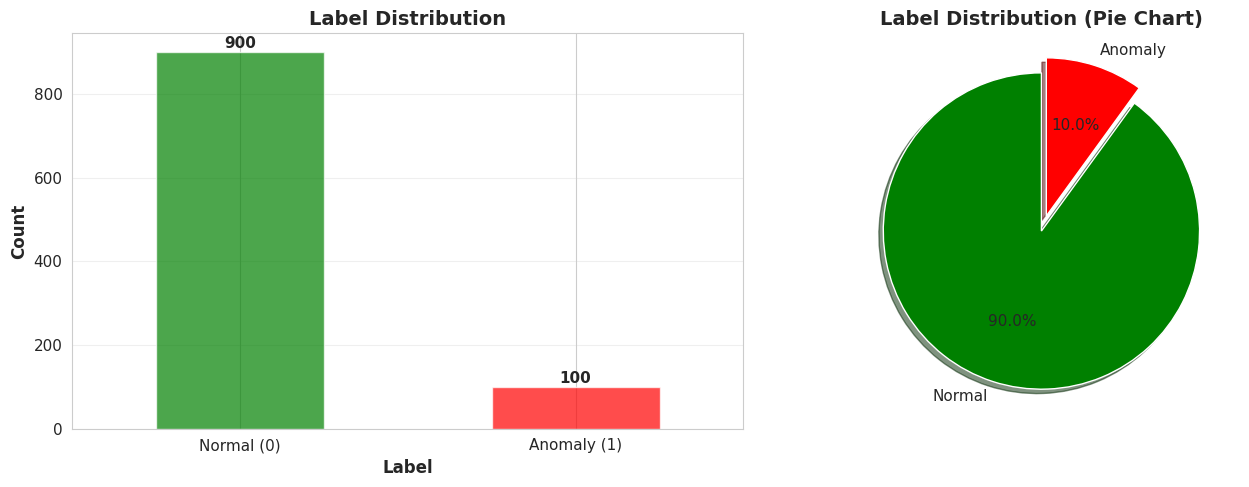


Label distribution plot saved to results/network_security/label_distribution.png ✅


In [3]:
print("-" * 80)
print("Label Distribution:")
print("-" * 80)

label_counts = df['label'].value_counts().sort_index()
print(f"\nNormal samples (0):   {label_counts[0.0]:>5} ({label_counts[0.0]/len(df)*100:.1f}%)")
print(f"Anomaly samples (1):  {label_counts[1.0]:>5} ({label_counts[1.0]/len(df)*100:.1f}%)")
print(f"Total:                {len(df):>5}")
print(f"\nContamination rate: {label_counts[1.0]/len(df):.2%}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
label_counts.plot(kind='bar', ax=ax1, color=['green', 'red'], alpha=0.7)

ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Label Distribution', fontsize=14, fontweight='bold')

ax1.set_xticklabels(['Normal (0)', 'Anomaly (1)'], rotation=0)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(label_counts):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

colors = ['green', 'red']
explode = (0, 0.1)  # Explode the anomaly slice
ax2.pie(label_counts, labels=['Normal', 'Anomaly'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, shadow=True)
ax2.set_title('Label Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/network_security/label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLabel distribution plot saved to results/network_security/label_distribution.png \u2705")

--------------------------------------------------------------------------------
Feature Correlation Analysis:
--------------------------------------------------------------------------------


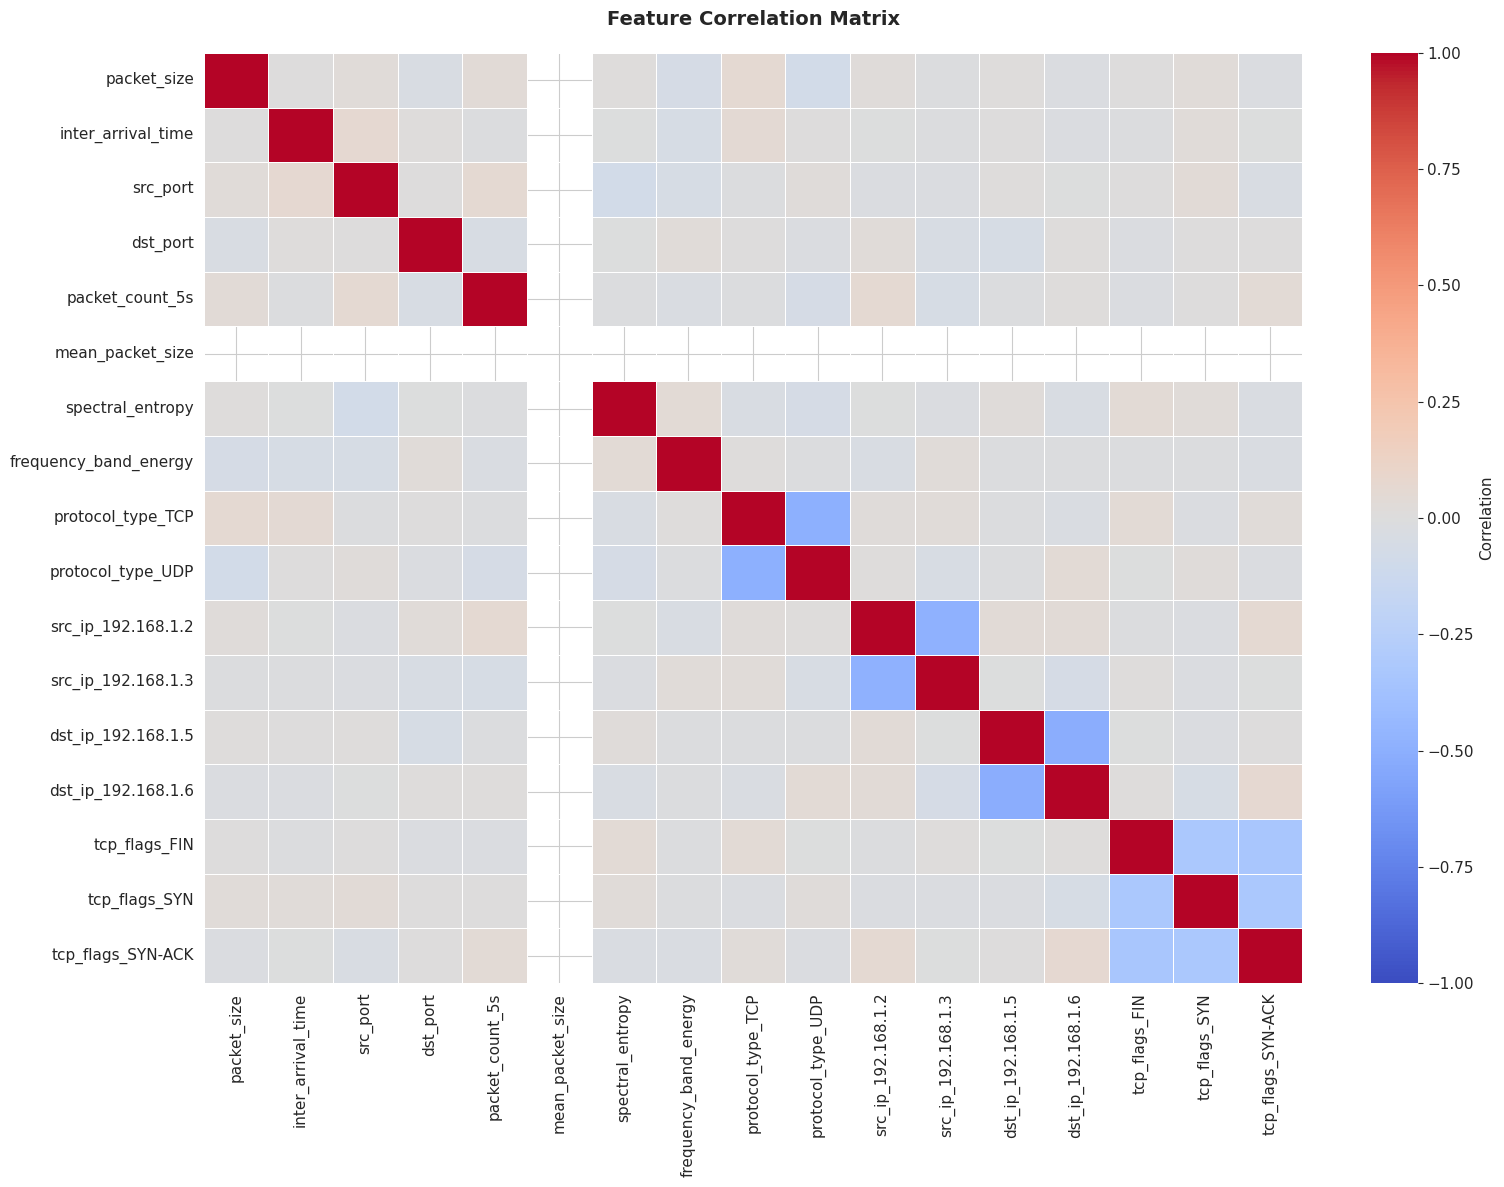


Correlation matrix saved to results/network_security/correlation_matrix.png ✅

No highly correlated features found (|r| > 0.7) ✅


In [4]:
print("-" * 80)
print("Feature Correlation Analysis:")
print("-" * 80)

X_raw = df.drop('label', axis=1)
y_raw = df['label'].values

# Compute correlation matrix
corr_matrix = X_raw.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'},
            ax=ax, fmt='.2f', vmin=-1, vmax=1)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/network_security/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation matrix saved to results/network_security/correlation_matrix.png \u2705")

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1:<30} <-> {feat2:<30}: {corr:>6.3f}")
else:
    print("\nNo highly correlated features found (|r| > 0.7) \u2705")

--------------------------------------------------------------------------------
Feature Distributions by Label:
--------------------------------------------------------------------------------


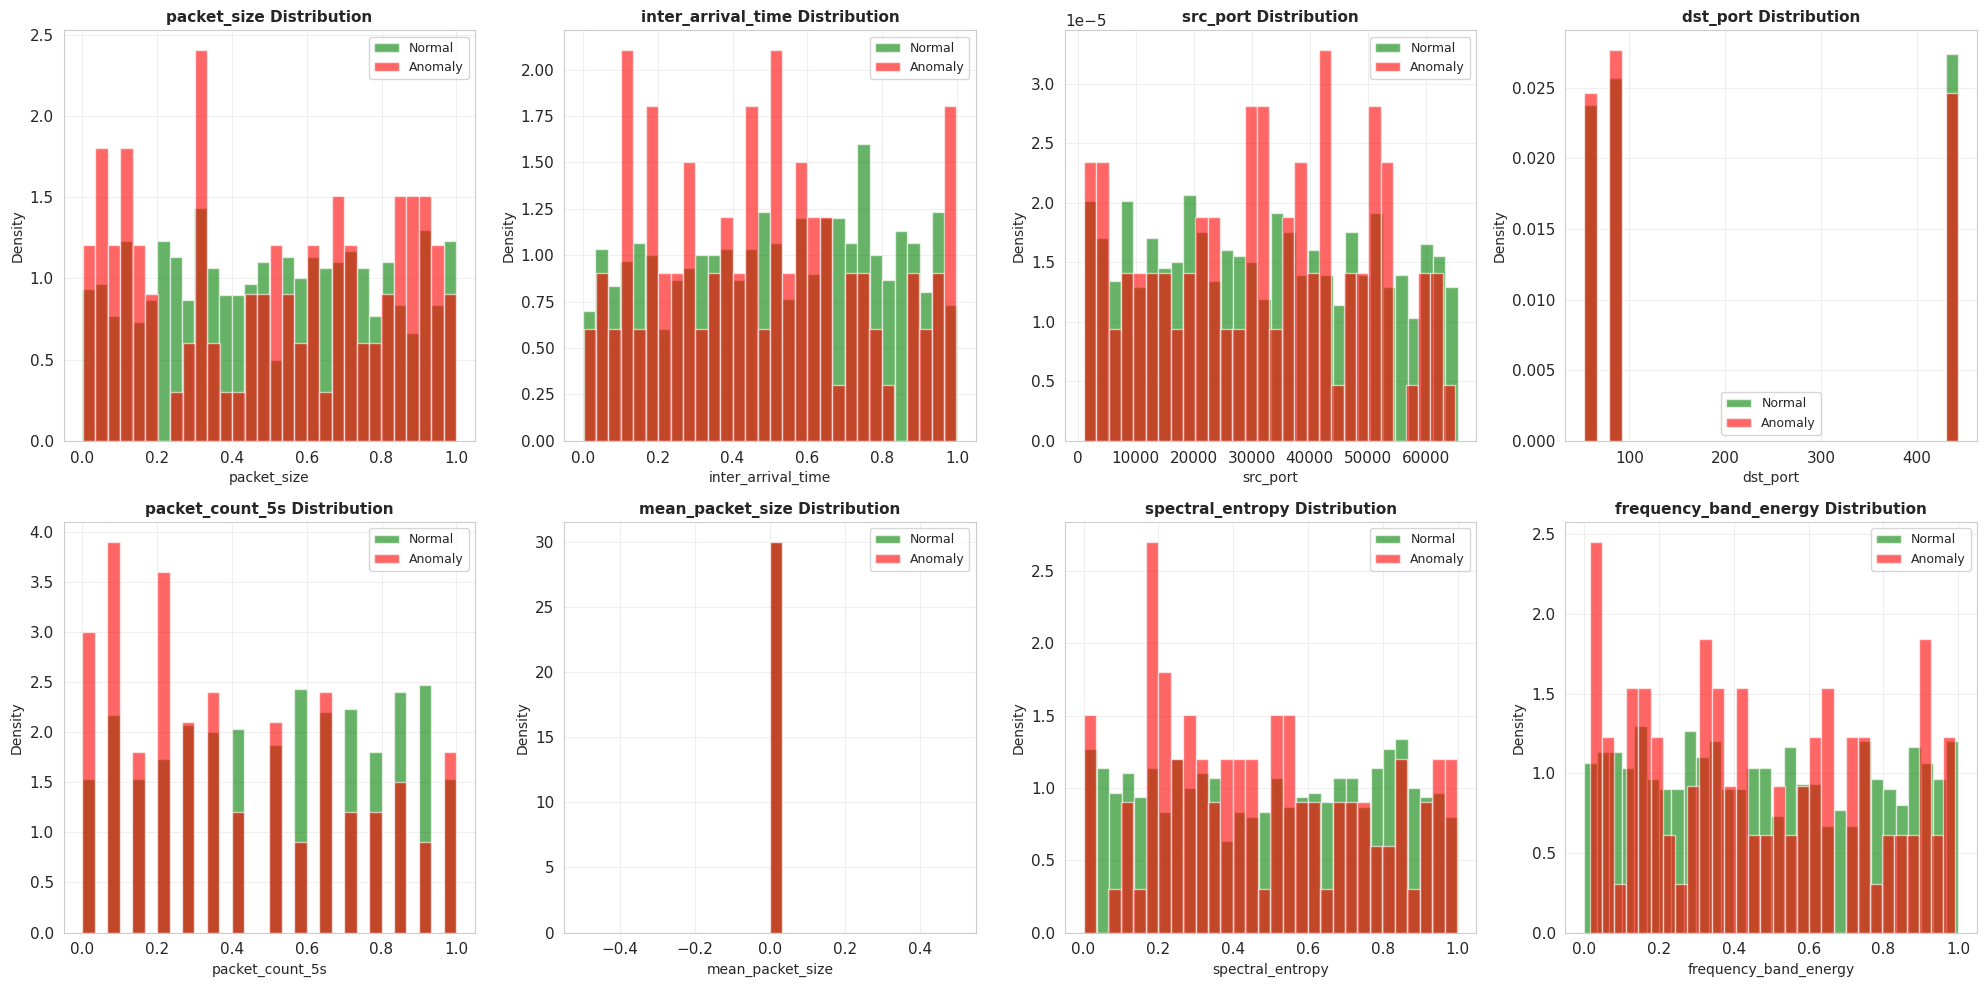


Feature distributions plot saved to results/network_security/feature_distributions.png ✅


In [5]:
print("-" * 80)
print("Feature Distributions by Label:")
print("-" * 80)

continuous_features = ['packet_size', 'inter_arrival_time', 'src_port', 'dst_port',
                        'packet_count_5s', 'mean_packet_size', 'spectral_entropy', 'frequency_band_energy']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

axes = axes.flatten()
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]
    
    # Separate by label
    normal_data = df[df['label'] == 0.0][feature]
    anomaly_data = df[df['label'] == 1.0][feature]
    
    # Plot distributions
    ax.hist(normal_data, bins=30, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(anomaly_data, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')

    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/network_security/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature distributions plot saved to results/network_security/feature_distributions.png \u2705")

## Section 2: Data Preprocessing

The dataset contains **boolean features** (True/False values) in columns like:
- `protocol_type_TCP`, `protocol_type_UDP` (protocol types)
- `src_ip_*`, `dst_ip_*` (one-hot encoded IP addresses)
- `tcp_flags_*` (TCP flags)

When pandas reads the CSV, these are interpreted as boolean dtype. However, our models and StandardScaler require **homogeneous numeric arrays**.

We explicitly convert all features to `float64`, which:
- Converts `True` → `1.0`
- Converts `False` → `0.0`
- Ensures compatibility with StandardScaler and our IsolationForest implementations

In [6]:
print("-" * 80)
print("Data Preprocessing")
print("-" * 80)

print("\nStep 1: Extract features and labels from DataFrame")
print("-" * 80)

X_raw = df.drop('label', axis=1).values
y = df['label'].values

print(f"Raw feature matrix dtype: {X_raw.dtype}")
print(f"Raw feature matrix shape: {X_raw.shape}")

bool_cols = df.drop('label', axis=1).select_dtypes(include=['bool']).columns.tolist()
print(f"\nBoolean columns detected: {len(bool_cols)}")
if bool_cols:
    print(f"  Examples: {bool_cols[:3]}...")

# Convert to float64 to handle boolean columns
# This converts: True → 1.0, False → 0.0
print("\nStep 2: Convert all features to float64 (including boolean → numeric)")
print("-" * 80)

X = X_raw.astype(np.float64)

print(f"Converted feature matrix dtype: {X.dtype}")
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Check boolean conversion
print("\nBoolean Conversion Verification:")
print("-" * 80)
if bool_cols:
    bool_col_idx = df.drop('label', axis=1).columns.get_loc(bool_cols[0])
    print(f"Column '{bool_cols[0]}':")
    print(f"  Original values (first 5): {X_raw[:5, bool_col_idx]}")
    print(f"  Converted values (first 5): {X[:5, bool_col_idx]}")
    print(f"  True → 1.0, False → 0.0")
else:
    print("  No boolean columns found")

# Check for any remaining non-numeric values
print("\nData Type Verification:")
print("-" * 80)
print(f"  All values are numeric: {np.issubdtype(X.dtype, np.number)}")
print(f"  Contains NaN values: {np.isnan(X).any()}")
print(f"  Contains Inf values: {np.isinf(X).any()}")
print(f"  Value range: [{X.min():.2f}, {X.max():.2f}]")


--------------------------------------------------------------------------------
Data Preprocessing
--------------------------------------------------------------------------------

Step 1: Extract features and labels from DataFrame
--------------------------------------------------------------------------------
Raw feature matrix dtype: object
Raw feature matrix shape: (1000, 17)

Boolean columns detected: 9
  Examples: ['protocol_type_TCP', 'protocol_type_UDP', 'src_ip_192.168.1.2']...

Step 2: Convert all features to float64 (including boolean → numeric)
--------------------------------------------------------------------------------
Converted feature matrix dtype: float64
Feature matrix shape: (1000, 17)
Label vector shape: (1000,)

Boolean Conversion Verification:
--------------------------------------------------------------------------------
Column 'protocol_type_TCP':
  Original values (first 5): [False False False False True]
  Converted values (first 5): [0. 0. 0. 0. 1.]
  Tr

In [8]:
# Train/test split with stratification
print("\nStep 3: Train/Test Split (80/20 with stratification)")
print("-" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n{'Split':<15} {'Samples':<10} {'Normal':<10} {'Anomaly':<10} {'Contamination':<15}")
print("=" * 60)
print(f"{'Training':<15} {len(X_train):<10} {np.sum(y_train==0):<10} {np.sum(y_train==1):<10} {np.mean(y_train):<15.2%}")
print(f"{'Test':<15} {len(X_test):<10} {np.sum(y_test==0):<10} {np.sum(y_test==1):<10} {np.mean(y_test):<15.2%}")
print(f"{'Total':<15} {len(X):<10} {np.sum(y==0):<10} {np.sum(y==1):<10} {np.mean(y):<15.2%}")

# Feature standardization
print("\nStep 4: Feature Standardization (StandardScaler)")
print("-" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized successfully")
print(f"Scaled data dtype: {X_train_scaled.dtype}")

print(f"\nTraining set statistics (after scaling):")
print(f"  Mean: {X_train_scaled.mean():.6f} (expected: ~0.0)")
print(f"  Std:  {X_train_scaled.std():.6f} (expected: ~1.0)")
print(f"  Min:  {X_train_scaled.min():.3f}")
print(f"  Max:  {X_train_scaled.max():.3f}")

print(f"\nTest set statistics (after scaling):")
print(f"  Mean: {X_test_scaled.mean():.6f}")
print(f"  Std:  {X_test_scaled.std():.6f}")
print(f"  Min:  {X_test_scaled.min():.3f}")
print(f"  Max:  {X_test_scaled.max():.3f}")

# Verify no issues after scaling
print("\nPost-Scaling Verification:")
print("-" * 80)
print(f"  Contains NaN: {np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any()}")
print(f"  Contains Inf: {np.isinf(X_train_scaled).any() or np.isinf(X_test_scaled).any()}")
print(f"  All finite values: {np.isfinite(X_train_scaled).all() and np.isfinite(X_test_scaled).all()}")

contamination = np.mean(y_train)
print(f"\nContamination rate for model training: {contamination:.2%}")

print("-" * 80)
print("Preprocessing Complete")
print("-" * 80)



Step 3: Train/Test Split (80/20 with stratification)
--------------------------------------------------------------------------------

Split           Samples    Normal     Anomaly    Contamination  
Training        800        720        80         10.00%         
Test            200        180        20         10.00%         
Total           1000       900        100        10.00%         

Step 4: Feature Standardization (StandardScaler)
--------------------------------------------------------------------------------

Features standardized successfully
Scaled data dtype: float64

Training set statistics (after scaling):
  Mean: -0.000000 (expected: ~0.0)
  Std:  0.970143 (expected: ~1.0)
  Min:  -1.850
  Max:  1.869

Test set statistics (after scaling):
  Mean: 0.015626
  Std:  0.980872
  Min:  -1.852
  Max:  1.869

Post-Scaling Verification:
--------------------------------------------------------------------------------
  Contains NaN: False
  Contains Inf: False
  All finite val

## Section 3: Model Training

In [9]:
print("-" * 80)
print("Model Training")
print("-" * 80)

# Hyperparameters
n_jobs = -1
random_state = 42
ensemble_size = 100
subsample_size = 256

print(f"\nHyperparameters:")
print(f"  ensemble_size:  {ensemble_size}")
print(f"  subsample_size: {subsample_size}")
print(f"  n_jobs:         {n_jobs} (all cores)")
print(f"  random_state:   {random_state}")
print(f"  contamination:  {contamination:.2%}")

results = {}

print("\n" + "-" * 80)
print("Training IsolationForest...")
print("-" * 80)

start_time = time.perf_counter()
forest_std = IsolationForest(
    ensemble_size=ensemble_size,
    n_jobs=n_jobs,
    random_state=random_state
)
forest_std.fit(X_train_scaled, subsample_size=subsample_size, contamination=contamination)
train_time_std = time.perf_counter() - start_time

print(f"Training completed in {train_time_std:.4f} seconds")
results['IsolationForest'] = {'train_time': train_time_std, 'model': forest_std}

print("\n" + "-" * 80)
print("Training KMeansIsolationForest...")
print("-" * 80)

start_time = time.perf_counter()
forest_kmeans = KMeansIsolationForest(
    ensemble_size=ensemble_size,
    n_jobs=n_jobs,
    random_state=random_state
)
forest_kmeans.fit(X_train_scaled, subsample_size=subsample_size, contamination=contamination)
train_time_kmeans = time.perf_counter() - start_time

print(f"Training completed in {train_time_kmeans:.4f} seconds")
results['KMeansIsolationForest'] = {'train_time': train_time_kmeans, 'model': forest_kmeans}

print("\n" + "-" * 80)
print("Training Time Summary:")
print("-" * 80)

print(f"{'Method':<30} {'Training Time (s)':<20} {'Relative Speed':<15}")
print("-" * 65)

print(f"{'IsolationForest':<30} {train_time_std:<20.4f} {'1.00x (baseline)':<15}")
print(f"{'KMeansIsolationForest':<30} {train_time_kmeans:<20.4f} {train_time_kmeans/train_time_std:<15.2f}x")

--------------------------------------------------------------------------------
Model Training
--------------------------------------------------------------------------------

Hyperparameters:
  ensemble_size:  100
  subsample_size: 256
  n_jobs:         -1 (all cores)
  random_state:   42
  contamination:  10.00%

--------------------------------------------------------------------------------
Training IsolationForest...
--------------------------------------------------------------------------------
Training completed in 2.1747 seconds

--------------------------------------------------------------------------------
Training KMeansIsolationForest...
--------------------------------------------------------------------------------
Training completed in 4.8054 seconds

--------------------------------------------------------------------------------
Training Time Summary:
--------------------------------------------------------------------------------
Method                         Tra

## Section 4: Model Evaluation

In [11]:
print("-" * 80)
print("Model Evaluation")
print("-" * 80)

print("\nGenerating predictions on test set\n")

# IsolationForest
start_time = time.perf_counter()
scores_std = forest_std.scores(X_test_scaled)
preds_std = forest_std.predict(X_test_scaled)
pred_time_std = time.perf_counter() - start_time

results['IsolationForest']['pred_time'] = pred_time_std
results['IsolationForest']['scores'] = scores_std
results['IsolationForest']['predictions'] = preds_std

# KMeansIsolationForest
start_time = time.perf_counter()
scores_kmeans = forest_kmeans.scores(X_test_scaled)
preds_kmeans = forest_kmeans.predict(X_test_scaled)
pred_time_kmeans = time.perf_counter() - start_time

results['KMeansIsolationForest']['pred_time'] = pred_time_kmeans
results['KMeansIsolationForest']['scores'] = scores_kmeans
results['KMeansIsolationForest']['predictions'] = preds_kmeans

print(f"{'Method':<30} {'Prediction Time (s)':<20}")
print("-" * 50)
print(f"{'IsolationForest':<30} {pred_time_std:<20.6f}")
print(f"{'KMeansIsolationForest':<30} {pred_time_kmeans:<20.6f}")

print("\n" + "-" * 80)
print("Performance Metrics:")
print("-" * 80)

metrics_data = []

for method_name, result in results.items():
    preds = result['predictions']
    scores = result['scores']
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds, zero_division=0)
    recall = recall_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, scores)
    avg_precision = average_precision_score(y_test, scores)
    
    result['metrics'] = {
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }
    
    metrics_data.append({
        'Method': method_name,
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision,
        'Train Time (s)': result['train_time'],
        'Pred Time (s)': result['pred_time']
    })
    
    print(f"\n{method_name}:")
    print("-" * 80)
    print(f"  Balanced Accuracy: {bal_acc:.4f}")
    print(f"  F1-Score:          {f1:.4f}")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    print(f"  ROC-AUC:           {roc_auc:.4f}")
    print(f"  PR-AUC:            {avg_precision:.4f}")

# Create DataFrame
df_metrics = pd.DataFrame(metrics_data)

print("\n" + "-" * 80)
print("Summary:")
print("-" * 80)

display(df_metrics)

# Save results
df_metrics.to_csv('../results/network_security/performance_metrics.csv', index=False)

print("\nMetrics saved to results/network_security/performance_metrics.csv \u2705")

--------------------------------------------------------------------------------
Model Evaluation
--------------------------------------------------------------------------------

Generating predictions on test set

Method                         Prediction Time (s) 
--------------------------------------------------
IsolationForest                0.252281            
KMeansIsolationForest          1.034692            

--------------------------------------------------------------------------------
Performance Metrics:
--------------------------------------------------------------------------------

IsolationForest:
--------------------------------------------------------------------------------
  Balanced Accuracy: 0.4944
  F1-Score:          0.1154
  Precision:         0.0938
  Recall:            0.1500
  ROC-AUC:           0.5239
  PR-AUC:            0.1156

KMeansIsolationForest:
--------------------------------------------------------------------------------
  Balanced Accuracy: 

,Method,Balanced Accuracy,F1-Score,Precision,Recall,ROC-AUC,PR-AUC,Train Time (s),Pred Time (s)
0,IsolationForest,0.494444,0.115385,0.093750,0.15,0.523889,0.115599,2.174733,0.252281
1,KMeansIsolationForest,0.466667,0.137255,0.085366,0.35,0.439722,0.108237,4.805415,1.034692



Metrics saved to results/network_security/performance_metrics.csv ✅


--------------------------------------------------------------------------------
Confusion Matrices:
--------------------------------------------------------------------------------


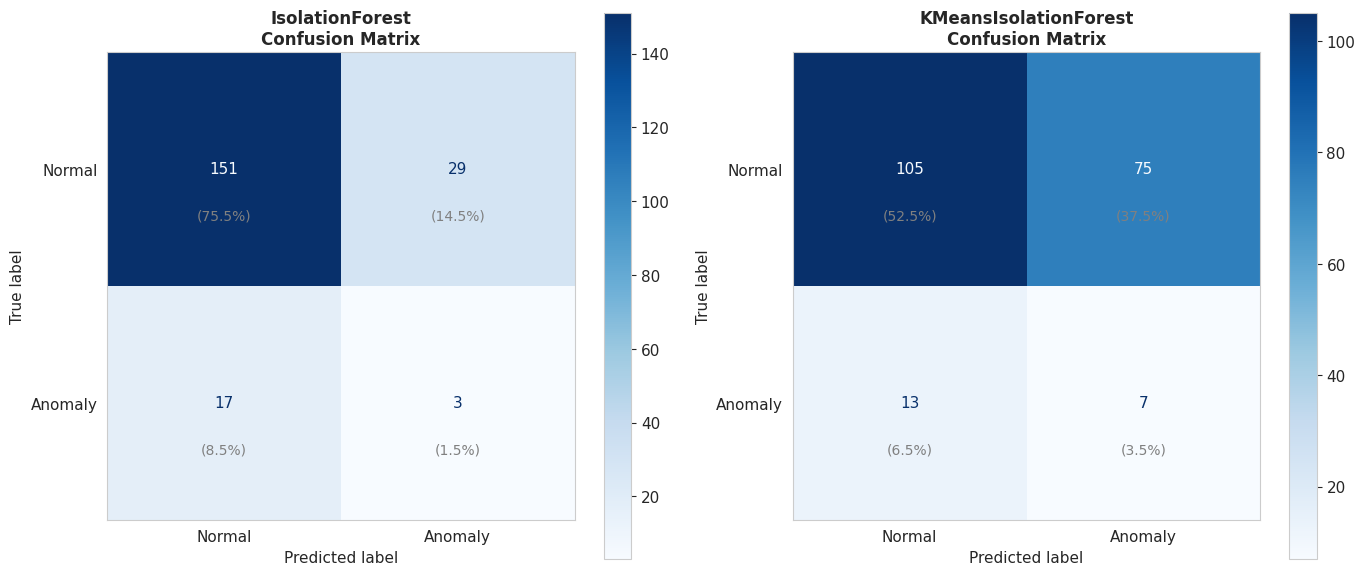


Confusion matrices saved to results/network_security/confusion_matrices.png ✅


In [12]:
print("-" * 80)
print("Confusion Matrices:")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (method_name, result) in enumerate(results.items()):
    ax = axes[idx]
    preds = result['predictions']
    
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    
    ax.set_title(f'{method_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.grid(False)
    
    # Add percentage annotations
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / cm.sum() * 100
            ax.text(j, i + 0.2, f'({percentage:.1f}%)', 
                   ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('../results/network_security/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrices saved to results/network_security/confusion_matrices.png \u2705")

--------------------------------------------------------------------------------
ROC Curves:
--------------------------------------------------------------------------------


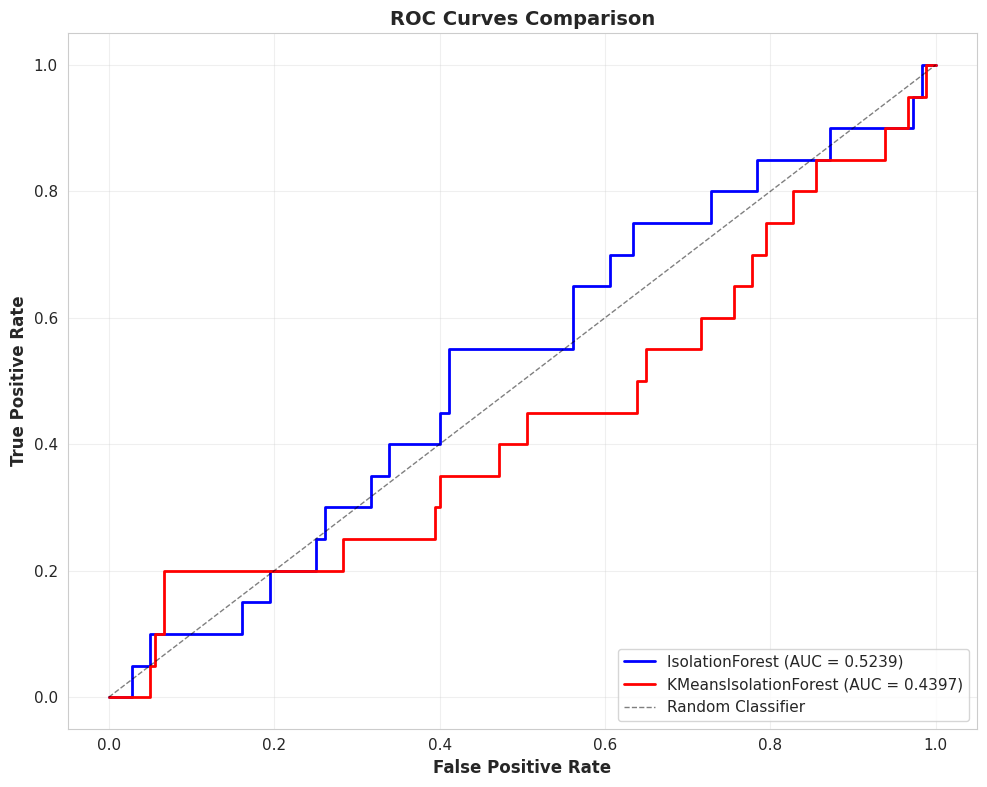


ROC curves saved to results/network_security/roc_curves.png ✅


In [14]:
print("-" * 80)
print("ROC Curves:")
print("-" * 80)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'red']
for idx, (method_name, result) in enumerate(results.items()):
    scores = result['scores']
    
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = result['metrics']['roc_auc']
    
    ax.plot(fpr, tpr, color=colors[idx], linewidth=2, 
            label=f'{method_name} (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')

ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/network_security/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC curves saved to results/network_security/roc_curves.png \u2705")

--------------------------------------------------------------------------------
Precision-Recall Curves:
--------------------------------------------------------------------------------


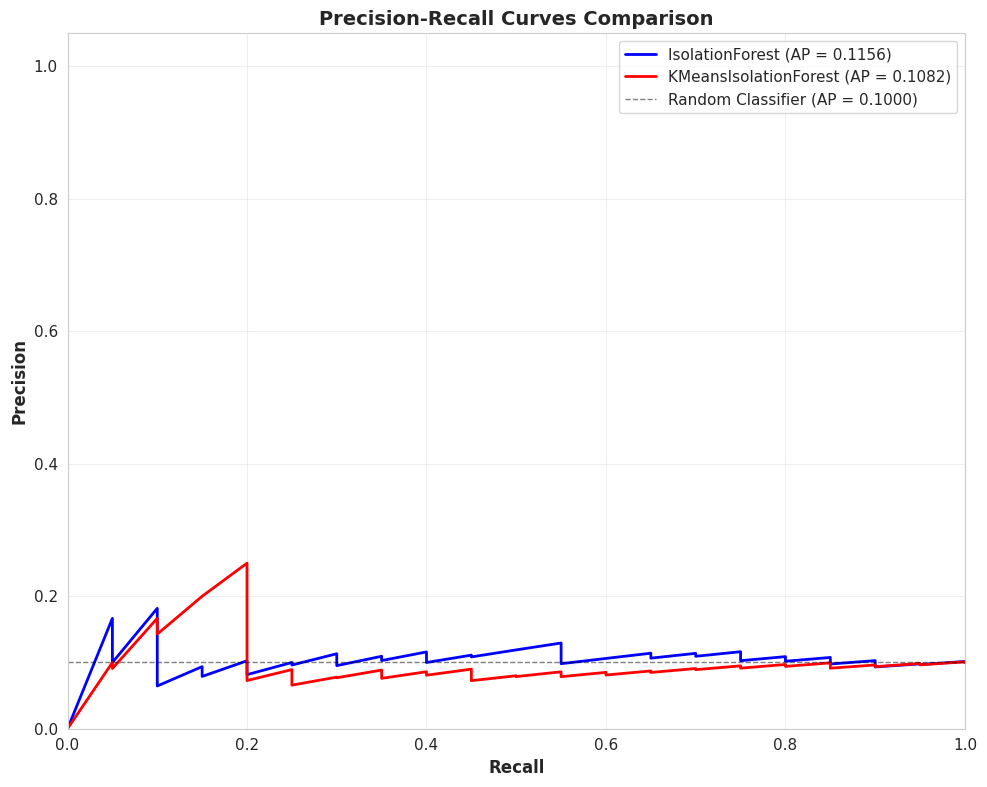


PR curves saved to results/network_security/pr_curves.png ✅


In [15]:
print("-" * 80)
print("Precision-Recall Curves:")
print("-" * 80)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'red']
for idx, (method_name, result) in enumerate(results.items()):
    scores = result['scores']
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores)
    avg_precision = result['metrics']['avg_precision']
    
    ax.plot(recall_curve, precision_curve, color=colors[idx], linewidth=2,
            label=f'{method_name} (AP = {avg_precision:.4f})')

# Plot baseline (random classifier)
baseline = np.mean(y_test)
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1, alpha=0.5,
           label=f'Random Classifier (AP = {baseline:.4f})')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')

ax.legend(loc='upper right', fontsize=11)

ax.grid(alpha=0.3)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('../results/network_security/pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPR curves saved to results/network_security/pr_curves.png \u2705")

--------------------------------------------------------------------------------
Anomaly Score Distributions:
--------------------------------------------------------------------------------


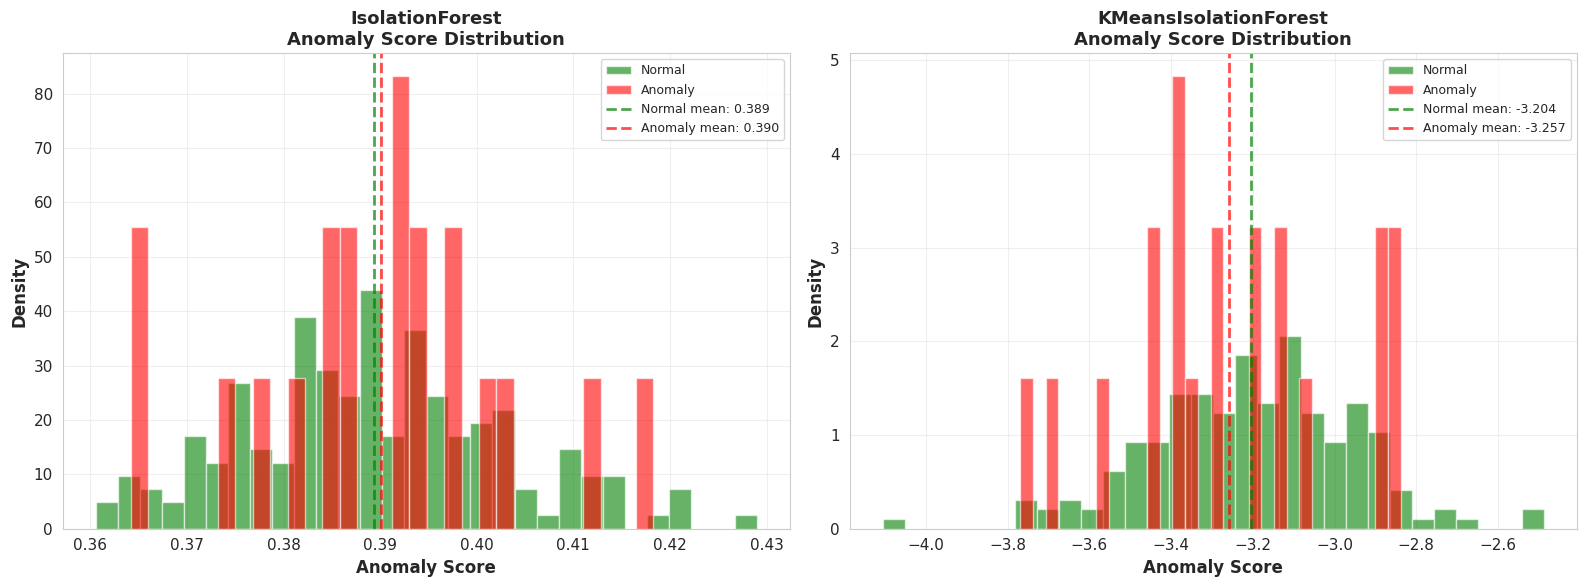


Score distributions saved to results/network_security/score_distributions.png ✅


In [16]:
print("-" * 80)
print("Anomaly Score Distributions:")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (method_name, result) in enumerate(results.items()):
    ax = axes[idx]
    scores = result['scores']
    
    normal_scores = scores[y_test == 0]
    anomaly_scores = scores[y_test == 1]
    
    ax.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
    
    ax.set_xlabel('Anomaly Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{method_name}\nAnomaly Score Distribution', fontsize=13, fontweight='bold')

    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # Add statistics
    normal_mean = np.mean(normal_scores)
    anomaly_mean = np.mean(anomaly_scores)

    ax.axvline(normal_mean, color='green', linestyle='--', linewidth=2, alpha=0.7,
              label=f'Normal mean: {normal_mean:.3f}')

    ax.axvline(anomaly_mean, color='red', linestyle='--', linewidth=2, alpha=0.7,
              label=f'Anomaly mean: {anomaly_mean:.3f}')

    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../results/network_security/score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nScore distributions saved to results/network_security/score_distributions.png \u2705")

## Section 5: Comparison & Insights

In [17]:
print("-" * 80)
print("Comparison & Insights")
print("-" * 80)

print("\nRank Correlation Analysis:")
print("-" * 80)

scores_std = results['IsolationForest']['scores']
scores_kmeans = results['KMeansIsolationForest']['scores']

# Calculate correlations
spearman_corr, spearman_p = spearmanr(scores_std, scores_kmeans)
kendall_corr, kendall_p = kendalltau(scores_std, scores_kmeans)
pearson_corr = np.corrcoef(scores_std, scores_kmeans)[0, 1]

print(f"\nScore Correlations:")
print(f"  Pearson correlation:  {pearson_corr:.4f}")
print(f"  Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")
print(f"  Kendall correlation:  {kendall_corr:.4f} (p-value: {kendall_p:.4e})")

# Calculate rank differences
ranks_std = np.argsort(np.argsort(scores_std))
ranks_kmeans = np.argsort(np.argsort(scores_kmeans))
rank_diff = np.abs(ranks_std - ranks_kmeans)

print(f"\nRank Difference Statistics:")
print(f"  Mean absolute difference:   {rank_diff.mean():.2f}")
print(f"  Median absolute difference: {np.median(rank_diff):.2f}")
print(f"  Max absolute difference:    {rank_diff.max():.0f}")
print(f"  Std dev of differences:     {rank_diff.std():.2f}")

--------------------------------------------------------------------------------
Comparison & Insights
--------------------------------------------------------------------------------

Rank Correlation Analysis:
--------------------------------------------------------------------------------

Score Correlations:
  Pearson correlation:  0.4276
  Spearman correlation: 0.3956 (p-value: 6.7112e-09)
  Kendall correlation:  0.2722 (p-value: 1.0448e-08)

Rank Difference Statistics:
  Mean absolute difference:   50.00
  Median absolute difference: 42.50
  Max absolute difference:    165
  Std dev of differences:     39.10


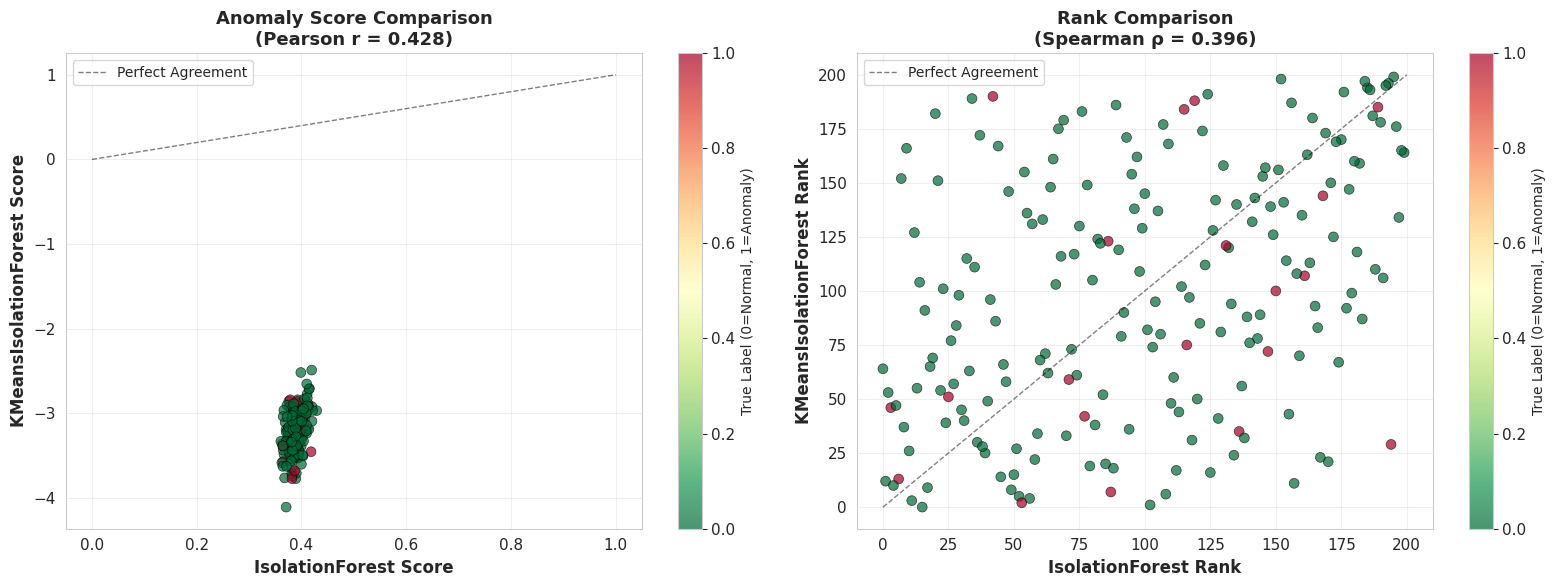


Correlation plots saved to results/network_security/score_rank_correlation.png ✅


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Score scatter plot
scatter = ax1.scatter(scores_std, scores_kmeans, c=y_test, 
                     cmap='RdYlGn_r', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Perfect Agreement')

ax1.set_xlabel('IsolationForest Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('KMeansIsolationForest Score', fontsize=12, fontweight='bold')
ax1.set_title(f'Anomaly Score Comparison\n(Pearson r = {pearson_corr:.3f})', 
             fontsize=13, fontweight='bold')

ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('True Label (0=Normal, 1=Anomaly)', fontsize=10)

# Right Plot: Rank scatter plot
scatter = ax2.scatter(ranks_std, ranks_kmeans, c=y_test,
                     cmap='RdYlGn_r', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

ax2.plot([0, len(y_test)], [0, len(y_test)], 'k--', linewidth=1, alpha=0.5, 
        label='Perfect Agreement')

ax2.set_xlabel('IsolationForest Rank', fontsize=12, fontweight='bold')
ax2.set_ylabel('KMeansIsolationForest Rank', fontsize=12, fontweight='bold')
ax2.set_title(f'Rank Comparison\n(Spearman ρ = {spearman_corr:.3f})',
             fontsize=13, fontweight='bold')

ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('True Label (0=Normal, 1=Anomaly)', fontsize=10)

plt.tight_layout()
plt.savefig('../results/network_security/score_rank_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation plots saved to results/network_security/score_rank_correlation.png \u2705")

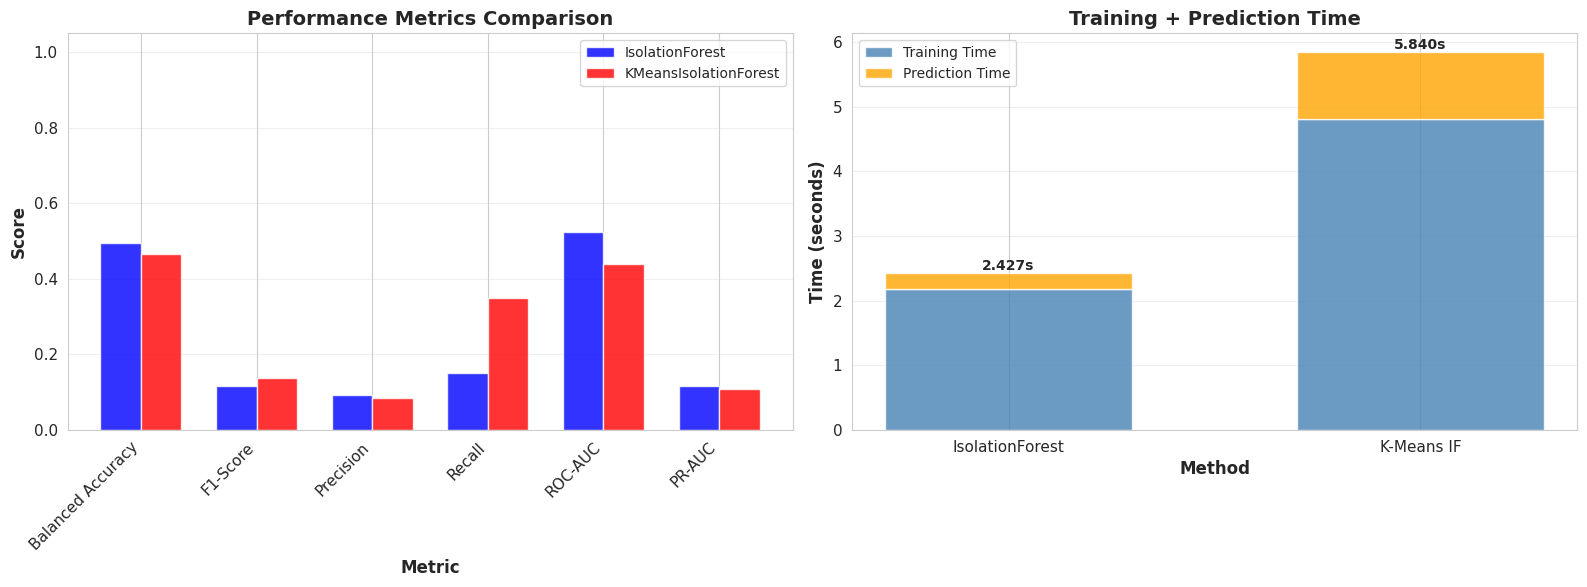


Performance summary saved to results/network_security/performance_summary.png ✅


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot Plot: Metric comparison (bar chart)
metrics_to_plot = ['Balanced Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

# Map display names to metric keys stored in results[...] ['metrics']
metric_key_map = {
    'Balanced Accuracy': 'balanced_accuracy',
    'F1-Score': 'f1_score',
    'Precision': 'precision',
    'Recall': 'recall',
    'ROC-AUC': 'roc_auc',
    'PR-AUC': 'avg_precision'  # alias: PR-AUC -> average precision
}

def get_metric(result_dict, display_name):
    key = metric_key_map.get(display_name, display_name.lower().replace('-', '_').replace(' ', '_'))
    return result_dict['metrics'].get(key, float('nan'))

std_values = [get_metric(results['IsolationForest'], m) for m in metrics_to_plot]
kmeans_values = [get_metric(results['KMeansIsolationForest'], m) for m in metrics_to_plot]

ax1.bar(x - width/2, std_values, width, label='IsolationForest', alpha=0.8, color='blue')
ax1.bar(x + width/2, kmeans_values, width, label='KMeansIsolationForest', alpha=0.8, color='red')

ax1.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')

ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')

ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Right Plot: Speed comparison (training + prediction time)
methods = ['IsolationForest', 'KMeansIsolationForest']
train_times = [results[m]['train_time'] for m in methods]
pred_times = [results[m]['pred_time'] for m in methods]

x_pos = np.arange(len(methods))
ax2.bar(x_pos, train_times, 0.6, label='Training Time', alpha=0.8, color='steelblue')
ax2.bar(x_pos, pred_times, 0.6, bottom=train_times, label='Prediction Time', 
        alpha=0.8, color='orange')

ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Training + Prediction Time', fontsize=14, fontweight='bold')

ax2.set_xticks(x_pos)
ax2.set_xticklabels(['IsolationForest', 'K-Means IF'], rotation=0)

ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add total time annotations
for i, method in enumerate(methods):
    total_time = results[method]['train_time'] + results[method]['pred_time']
    ax2.text(i, total_time + 0.05, f'{total_time:.3f}s', 
            ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../results/network_security/performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPerformance summary saved to results/network_security/performance_summary.png \u2705")

In [21]:
print("-" * 80)
print("SUMMARY")
print("-" * 80)

print("\n1. ACCURACY COMPARISON:")
print("-" * 80)
for method in ['IsolationForest', 'KMeansIsolationForest']:
    metrics = results[method]['metrics']
    print(f"\n{method}:")
    print(f"  F1-Score:          {metrics['f1_score']:.4f}")
    print(f"  Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"  ROC-AUC:           {metrics['roc_auc']:.4f}")

print("\n2. SPEED COMPARISON:")
print("-" * 80)
for method in ['IsolationForest', 'KMeansIsolationForest']:
    print(f"\n{method}:")
    print(f"  Training time:   {results[method]['train_time']:.4f}s")
    print(f"  Prediction time: {results[method]['pred_time']:.6f}s")
    print(f"  Total time:      {results[method]['train_time'] + results[method]['pred_time']:.4f}s")

print("\n3. SCORE CORRELATION:")
print("-" * 80)
print(f"  Spearman rank correlation: {spearman_corr:.4f}")
print(f"  Interpretation: {'Strong' if abs(spearman_corr) > 0.7 else 'Moderate' if abs(spearman_corr) > 0.5 else 'Weak'} agreement")

print("\n4. KEY INSIGHTS:")
print("-" * 80)

# Determine winner for accuracy
f1_std = results['IsolationForest']['metrics']['f1_score']
f1_kmeans = results['KMeansIsolationForest']['metrics']['f1_score']
accuracy_winner = 'IsolationForest' if f1_std > f1_kmeans else 'KMeansIsolationForest'
accuracy_margin = abs(f1_std - f1_kmeans)

# Determine winner for speed
time_std = results['IsolationForest']['train_time'] + results['IsolationForest']['pred_time']
time_kmeans = results['KMeansIsolationForest']['train_time'] + results['KMeansIsolationForest']['pred_time']
speed_winner = 'IsolationForest' if time_std < time_kmeans else 'KMeansIsolationForest'
speedup = max(time_std, time_kmeans) / min(time_std, time_kmeans)

print(f"\n  Accuracy: {accuracy_winner} performs {'marginally' if accuracy_margin < 0.05 else 'significantly'} better")
print(f"    (F1-Score difference: {accuracy_margin:.4f})")

print(f"\n  Speed: {speed_winner} is {speedup:.2f}x faster")

if spearman_corr > 0.7:
    print(f"\n  Both methods show strong agreement in anomaly ranking (ρ={spearman_corr:.3f})")
else:
    print(f"\n  Methods show moderate agreement in anomaly ranking (ρ={spearman_corr:.3f})")
    print(f"    This suggests different anomaly detection strategies")

print("\n5. RECOMMENDATIONS:")
print("-" * 80)
if accuracy_margin < 0.05:
    print("\n  Both methods show comparable accuracy on this network security dataset")
    print(f"   For production use, choose {speed_winner} for better performance")
else:
    print(f"\n  {accuracy_winner} shows superior detection accuracy")
    print(f"  {speed_winner} offers better computational efficiency")
    print("  Choose based on your priority: accuracy vs speed")

print("\n" + "-" * 80)
print("All results saved to: results/network_security/ \u2705")
print("-" * 80)

--------------------------------------------------------------------------------
SUMMARY
--------------------------------------------------------------------------------

1. ACCURACY COMPARISON:
--------------------------------------------------------------------------------

IsolationForest:
  F1-Score:          0.1154
  Balanced Accuracy: 0.4944
  ROC-AUC:           0.5239

KMeansIsolationForest:
  F1-Score:          0.1373
  Balanced Accuracy: 0.4667
  ROC-AUC:           0.4397

2. SPEED COMPARISON:
--------------------------------------------------------------------------------

IsolationForest:
  Training time:   2.1747s
  Prediction time: 0.252281s
  Total time:      2.4270s

KMeansIsolationForest:
  Training time:   4.8054s
  Prediction time: 1.034692s
  Total time:      5.8401s

3. SCORE CORRELATION:
--------------------------------------------------------------------------------
  Spearman rank correlation: 0.3956
  Interpretation: Weak agreement

4. KEY INSIGHTS:
------------